# Inverter Based Amplifier

In [172]:
import sympy as sp
from scipy.optimize import minimize
import numpy as np
import ltspice
from scipy.signal import TransferFunction, bode
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import re

### Loading values of parameters

In [173]:
# Arrays to store the results of the simulations
param_values = np.zeros(19)    # order: Vdd, Wn, Ln, Wp, Lp, Wr1, Lr1, R_1, Wr2, Lr2, R_2, Wc1, Lc1, MFc1, C_1, Wc2, Lc2, Mfc2, C_2 Vdc

def extract_spice_params(file_path):
    # Parameters to extract
    params = {
        'Vdd': None,
        'Wn': None,
        'Ln': None,
        'Wp': None,
        'Lp': None,
        'Wr1': None,
        'Lr1': None,
        'R_1': None,
        'Wr2': None,
        'Lr2': None,
        'R_2': None,
        'Wc1': None,
        'Lc1': None,
        'MFc1': None,
        'C_1': None,
        'Wc2': None,
        'Lc2': None,
        'MFc2': None,
        'C_2': None,
        'Vdc': None
    }
    
    # Open and read the SPICE file
    with open(file_path, 'r') as file:
        content = file.readlines()
    
    # Regex patterns to capture values
    patterns = {
        'Vdd': r'VP VCC GND (\d+\.?\d*)',
        'Vdc': r'Vin in GND (\d+\.?\d*) ac',
        'Wn': r'x1 test net1 VCC VSS not W_N=(\d+\.?\d*) L_N=',  # Adjusted to target the specific line
        'Ln': r'x1 test net1 VCC VSS not .*L_N=(\d+\.?\d*) W_P=',  # Adjusted to target the specific line
        'Wp': r'x1 test net1 VCC VSS not .*W_P=(\d+\.?\d*)',
        'Lp': r'x1 test net1 VCC VSS not .*L_P=(\d+\.?\d*) m=',  # Adjusted to target the specific line
        'Wr1': r'XR1 .+ W=(\d+\.?\d*) L=',
        'Lr1': r'XR1 .+ L=(\d+\.?\d*) mult=',
        'R_1': r'XR1 .+ mult=(\d+\.?\d*)',
        'Wr2': r'XR2 .+ W=(\d+\.?\d*) L=',
        'Lr2': r'XR2 .+ L=(\d+\.?\d*) mult=',
        'R_2': r'XR2 .+ mult=(\d+\.?\d*)',
        'Wc1': r'XC1 .+ W=(\d+\.?\d*) L=',
        'Lc1': r'XC1 .+ L=(\d+\.?\d*)',
        'MFc1': r'XC1 .+ MF=(\d+\.?\d*) m=',
        'Wc2': r'XC2 .+ W=(\d+\.?\d*) L=',
        'Lc2': r'XC2 .+ L=(\d+\.?\d*)',
        'MFc2': r'XC2 .+ MF=(\d+\.?\d*) m='
    }
    
    # Extract parameters
    for line in content:
        for key, pattern in patterns.items():
            match = re.search(pattern, line)
            if match:
                params[key] = float(match.group(1))

    # Calculate capacitance using the given formula
    if params['Wc1'] and params['Lc1'] and params['MFc1']:
        params['C_1'] = params['MFc1'] * params['Wc1'] * params['Lc1']  # Simple multiplication
    
    # Calculate capacitance using the given formula
    if params['Wc2'] and params['Lc2'] and params['MFc2']:
        params['C_2'] = params['MFc2'] * params['Wc2'] * params['Lc2']  # Simple multiplication

    # Convert to NumPy array
    param_values = np.array([params[key] for key in params], dtype=float)
    
    return param_values

# Usage
file_path = "../netlist/tb_inv_sky130_a.spice"
param_values = extract_spice_params(file_path)
print("The values of the parameters are: ")
print("Vdd = ", param_values[0])
print("Wn = ", param_values[1])
print("Ln = ", param_values[2])
print("Wp = ", param_values[3])
print("Lp = ", param_values[4])
print("Wr1 = ", param_values[5])
print("Lr1 = ", param_values[6])
param_values[7] = 2e3*param_values[6]/param_values[5]
print("R_1 = ", param_values[7])
print("Wr2 = ", param_values[8])
print("Lr2 = ", param_values[9])
param_values[10] = 2e3*param_values[9]/param_values[8]
print("R_2 = ", param_values[10])
print("Wc1 = ", param_values[11])
print("Lc1 = ", param_values[12])
print("MFc1 = ", param_values[13])
param_values[14] = param_values[13] * (param_values[11] * param_values[12] * 2e-15 + (param_values[11] + param_values[12]) * 0.38e-15)
print("C_1 = ", param_values[14])
print("Wc2 = ", param_values[15])
print("Lc2 = ", param_values[16])
print("MFc2 = ", param_values[17])
param_values[18] = param_values[17] * (param_values[16] * param_values[15] * 2e-15 + (param_values[16] + param_values[15]) * 0.38e-15)
print("C_2 = ", param_values[18])
print("Vdc = ", param_values[19])

R1_value = param_values[7]
R2_value = param_values[10]
C1_value = param_values[14]*1e15   # Convert to fF
C2_value = param_values[18]*1e15    # Convert to fF


The values of the parameters are: 
Vdd =  1.125
Wn =  250.0
Ln =  1.0
Wp =  200.0
Lp =  0.25
Wr1 =  0.15
Lr1 =  90000.0
R_1 =  1200000000.0
Wr2 =  0.15
Lr2 =  10.0
R_2 =  133333.33333333334
Wc1 =  22.0
Lc1 =  22.0
MFc1 =  1.0
C_1 =  9.8472e-13
Wc2 =  150.0
Lc2 =  150.0
MFc2 =  1.0
C_2 =  4.511400000000001e-11
Vdc =  0.44866


In [174]:
op = np.zeros(8)    # order: G_mn, G_mp, G_dsn, G_dsp, C_gsn, C_gsp, C_gdn, C_gdp

filepath = '../netlist/tb_inv_sky130_a_op.raw'  # Update to your file's path

# Load the LTSpice file
lt = ltspice.Ltspice(filepath)
lt.parse()

# Get the data by specifying the trace name
gmn = lt.get_data('gmn')
gmp = lt.get_data('gmp')
gdsn = lt.get_data('gdsn')
gdsp = lt.get_data('gdsp')
cgsn = lt.get_data('cgsn')
cgsp = lt.get_data('cgsp')
cgdn = lt.get_data('cgdn')
cgdp = lt.get_data('cgdp')
# Create numpy array
#The values are stored in the following order: G_mn, G_mp, G_dsn, G_dsp, C_gsn, C_gsp
op = np.array([gmn, gmp, gdsn, gdsp, abs(cgsn), abs(cgsp), abs(cgdn), abs(cgdp)]).flatten()
print("The operating point values are:")
print("gmn = ", op[0])
print("gmp = ", op[1])
print("gdsn = ", op[2])
print("gdsp = ", op[3])
print("cgsn = ", op[4])
print("cgsp = ", op[5])
print("cgdn = ", op[6])
print("cgdp = ", op[7])

[Warning] Variable data type is detected as double precision.
The operating point values are:
gmn =  6.949338188224967e-05
gmp =  5.006511471824786e-05
gdsn =  5.284095083949141e-07
gdsp =  1.586035771861527e-06
cgsn =  6.107781978199651e-13
cgsp =  6.140522673936459e-14
cgdn =  6.394110997298584e-16
cgdp =  1.1165345440267443e-17


## Transfer function

### Using the driving point signal flow graph of this circuit, we find the transfer function easily. For more information about this technique, see: Schmid, Hanspeter, et Alex Huber. « Analysis of Switched-Capacitor Circuits Using Driving-Point Signal-Flow Graphs ». Analog Integrated Circuits and Signal Processing 96, nᵒ 3 (septembre 2018): 495‑507. https://doi.org/10.1007/s10470-018-1131-7.


### Transfer function and signal flow graph

#### Driving Point Signal Flow Graph:

In [175]:
Delta = sp.symbols('Delta')
L1,L2 = sp.symbols('L1,L2')
T_num = sp.symbols('T_num')
T_den = sp.symbols('T_den')
T_io = sp.symbols('T_io')
G_dsn,C_2,G_dsp,C_gdp,R_1,C_gsn,C_1,G_mn,C_gsp,G_mp,s,C_gdn,R_2 = sp.symbols('G_dsn,C_2,G_dsp,C_gdp,R_1,C_gsn,C_1,G_mn,C_gsp,G_mp,s,C_gdn,R_2')

loops = [(L1, (C_gdn*s + C_gdp*s + 1/R_1)*(C_gdn*s + C_gdp*s - G_mn - G_mp + 1/R_1)/((C_1*s + C_gdn*s + C_gdp*s + C_gsn*s + C_gsp*s + 1/R_1)*(C_gdn*s + C_gdp*s + G_dsn + G_dsp + 1/R_2 + 1/R_1))), (L2, 1/(R_2**2*(C_2*s + 1/R_2)*(C_gdn*s + C_gdp*s + G_dsn + G_dsp + 1/R_2 + 1/R_1)))]
determinant = [(Delta, -L1 - L2 + 1)]
denominator = [(T_den, Delta)]

P1,D1 = sp.symbols('P1,D1')
paths = [(P1, C_1*s*(C_gdn*s + C_gdp*s - G_mn - G_mp + 1/R_1)/(R_2*(C_2*s + 1/R_2)*(C_1*s + C_gdn*s + C_gdp*s + C_gsn*s + C_gsp*s + 1/R_1)*(C_gdn*s + C_gdp*s + G_dsn + G_dsp + 1/R_2 + 1/R_1))), (D1, 1)]
numerator = [(T_num, D1*P1)]

transfer_function = [(T_io, T_num/T_den)]
T=T_io.subs(transfer_function).subs(numerator).subs(denominator).subs(determinant).subs(paths).subs(loops).simplify()

print("The transfer function is: ")
display(T)

The transfer function is: 


-C_1*R_1*R_2*s*(R_1*(C_gdn*s + C_gdp*s - G_mn - G_mp) + 1)/(R_1*(R_1*s*(C_1 + C_gdn + C_gdp + C_gsn + C_gsp) + 1) + R_2*(R_1*(C_gdn*s + C_gdp*s - G_mn - G_mp) + 1)*(C_2*R_2*s + 1)*(R_1*s*(C_gdn + C_gdp) + 1) - (C_2*R_2*s + 1)*(R_1*s*(C_1 + C_gdn + C_gdp + C_gsn + C_gsp) + 1)*(R_1*R_2*(C_gdn*s + C_gdp*s + G_dsn + G_dsp) + R_1 + R_2))

#### Frequency response

The peak gain is approximately 28.89 dB
The lower cutoff frequency is approximately 2736.80 Hz
The upper cutoff frequency is approximately 9.71 kHz


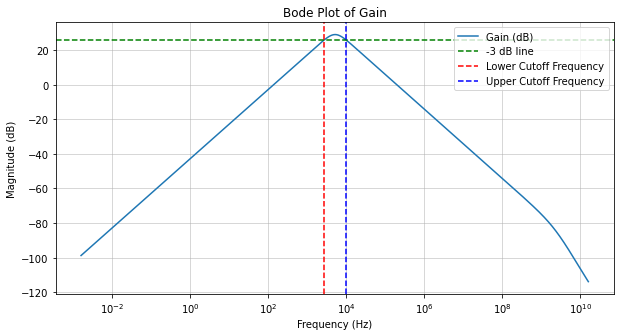

In [176]:
T_num = T.subs([(G_mn, op[0]), (G_mp, op[1]), (G_dsn, op[2]), 
                (G_dsp, op[3]), (C_gsn, op[4]), (C_gsp, op[5]),
                (C_gdn, op[6]), (C_gdp, op[7]),
                (R_1, param_values[7]), (R_2, param_values[10]),
                (C_1, param_values[14]), (C_2, param_values[18])])

# Replace this example with your actual transfer function
num, den = sp.fraction(T_num)  # T is your transfer function in symbolic form
num = sp.expand(num)
den = sp.expand(den)
num_coeffs = [float(c) for c in sp.Poly(num, s).all_coeffs()]
den_coeffs = [float(c) for c in sp.Poly(den, s).all_coeffs()]

sys = TransferFunction(num_coeffs, den_coeffs)

w, mag, phase = bode(sys, n=10000)

# Convert magnitude in dB to numpy array
mag_array = np.array(mag)

# Calculate the peak gain
peak_gain = np.max(mag_array)
peak_gain_index = np.argmax(mag_array)

# Find the lower cutoff frequency by searching to the left of the peak gain index
left_side = mag_array[:peak_gain_index]
lower_cutoff_indices = np.where(left_side <= peak_gain - 3)[0]
lower_cutoff_frequency = w[lower_cutoff_indices[-1]] / (2 * np.pi) if lower_cutoff_indices.size > 0 else None

# For the upper cutoff frequency, find the closest to the simulation result (your method)
upper_cutoff_index = np.argmin(np.abs(mag_array[peak_gain_index:] - (peak_gain - 3))) + peak_gain_index
upper_cutoff_frequency = w[upper_cutoff_index] / (2 * np.pi)

# Print the results
print(f"The peak gain is approximately {peak_gain:.2f} dB")
print(f"The lower cutoff frequency is approximately {lower_cutoff_frequency:.2f} Hz" if lower_cutoff_frequency else "Lower cutoff frequency not found.")
print(f"The upper cutoff frequency is approximately {upper_cutoff_frequency/1e3:.2f} kHz" if upper_cutoff_frequency else "Upper cutoff frequency not found.")

# Plot the Bode plot for gain
plt.figure(figsize=(10, 5))
plt.semilogx(w / (2 * np.pi), mag_array, label='Gain (dB)')
plt.axhline(y=peak_gain - 3, color='green', linestyle='--', label='-3 dB line')
if lower_cutoff_frequency:
    plt.axvline(x=lower_cutoff_frequency, color='red', linestyle='--', label='Lower Cutoff Frequency')
if upper_cutoff_frequency:
    plt.axvline(x=upper_cutoff_frequency, color='blue', linestyle='--', label='Upper Cutoff Frequency')
plt.title('Bode Plot of Gain')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(which='both', linestyle='-', linewidth=0.5)
plt.legend()
plt.show()


#### Iterative help

In [177]:
# Function to create a transfer function and plot it
T_temp = T.subs([(G_mn, op[0]), (G_mp, op[1]), (G_dsn, op[2]),
                (G_dsp, op[3]), (C_gsn, op[4]), (C_gsp, op[5]),
                (C_gdn, op[6]), (C_gdp, op[7]),
                (C_1, param_values[14])])
def update_plot(R1_val, R2_val, C2_val):
    param_values = {R_1: R1_val, R_2: R2_val, C_2: C2_val}  # C1 fixed
    T_num_eval = T_temp.subs(param_values)
    num, den = sp.fraction(T_num_eval)  # Assumes T is your transfer function in symbolic form
    num = sp.expand(num)
    den = sp.expand(den)
    num_coeffs = [float(c) for c in sp.Poly(num, s).all_coeffs()]
    den_coeffs = [float(c) for c in sp.Poly(den, s).all_coeffs()]
    
    sys = TransferFunction(num_coeffs, den_coeffs)
    w, mag, phase = bode(sys, 10000)
    
    # Convert magnitude in dB to numpy array
    mag_array = np.array(mag)

    # Convert magnitude in dB to numpy array
    mag_array = np.array(mag)

    # Calculate the peak gain
    peak_gain = np.max(mag_array)
    peak_gain_index = np.argmax(mag_array)

    # Find the lower cutoff frequency by searching to the left of the peak gain index
    left_side = mag_array[:peak_gain_index]
    lower_cutoff_indices = np.where(left_side <= peak_gain - 3)[0]
    lower_cutoff_frequency = w[lower_cutoff_indices[-1]] / (2 * np.pi) if lower_cutoff_indices.size > 0 else None

    # For the upper cutoff frequency, find the closest to the simulation result (your method)
    upper_cutoff_index = np.argmin(np.abs(mag_array[peak_gain_index:] - (peak_gain - 3))) + peak_gain_index
    upper_cutoff_frequency = w[upper_cutoff_index] / (2 * np.pi)
    
    # Print the results
    print(f"The peak gain is approximately {peak_gain:.2f} dB")
    print(f"The lower cutoff frequency is approximately {lower_cutoff_frequency:.2f} Hz" if lower_cutoff_frequency else "Lower cutoff frequency not found.")
    print(f"The upper cutoff frequency is approximately {upper_cutoff_frequency/1e3:.2f} kHz" if upper_cutoff_frequency else "Upper cutoff frequency not found.")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.semilogx(w / (2 * np.pi), mag_array, label='Gain (dB)')
    plt.title('Bode Plot of Gain')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.grid(True)
    plt.legend()
    plt.show()

# Create sliders for R1, R2, C2
R1_slider = widgets.FloatLogSlider(value=param_values[7], base=10, min=0, max=10, step=0.1, description='R1 (Ohms)')
R2_slider = widgets.FloatLogSlider(value=param_values[10], base=10, min=0, max=9, step=0.1, description='R2 (Ohms)')
C2_slider = widgets.FloatLogSlider(value=param_values[18], base=10, min=-15, max=-10, step=0.1, description='C2 (Farads)')

In [178]:

# Display the interactive output
widgets.interactive(update_plot, R1_val=R1_slider, R2_val=R2_slider, C2_val=C2_slider)

interactive(children=(FloatLogSlider(value=1200000000.0, description='R1 (Ohms)', max=10.0), FloatLogSlider(va…